# Dependencies

In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load data

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 30
WARMUP_EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 256
WIDTH = 256
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 7
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [4]:
def kappa(y_true, y_pred, n_classes=5):
    y_trues = K.cast(K.argmax(y_true), K.floatx())
    y_preds = K.cast(K.argmax(y_pred), K.floatx())
    n_samples = K.cast(K.shape(y_true)[0], K.floatx())
    distance = K.sum(K.abs(y_trues - y_preds))
    max_distance = n_classes - 1
    
    kappa_score = 1 - ((distance**2) / (n_samples * (max_distance**2)))

    return kappa_score


def step_decay(epoch):
    lrate = 30e-5
    if epoch > 3:
        lrate = 15e-5
    if epoch > 7:
        lrate = 7.5e-5
    if epoch > 11:
        lrate = 3e-5
    if epoch > 15:
        lrate = 1e-5

    return lrate


def focal_loss(y_true, y_pred):
    gamma = 2.0
    epsilon = K.epsilon()
    
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    
    return loss


def get_1cycle_schedule(lr_max=1e-3, n_data_points=8000, epochs=200, batch_size=40, verbose=0):          
    """
    Creates a look-up table of learning rates for 1cycle schedule with cosine annealing
    See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py
    Wrote this to use with my Keras and (non-fastai-)PyTorch codes.
    Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
      So see below for Keras callback

    Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
    Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
    Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
    """
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs


class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.

    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0],
        epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

# Train test split

In [5]:
X_train, X_val = train_test_split(train, test_size=0.25, random_state=0)

# Data generator

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[1, 1.2],
                                 zca_whitening=True,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='reflect',
                                 cval=0.)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH))

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH))

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH))

Found 2746 validated image filenames belonging to 5 classes.
Found 916 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [7]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['diagnosis'].astype('int').values), train['diagnosis'].astype('int').values)

metric_list = ["accuracy", kappa]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weights,
                                     verbose=1).history

Epoch 1/1
343/343 [==============================] - 429s 1s/step - loss: 1.4432 - acc: 0.6243 - kappa: 0.7211 - val_loss: 1.3867 - val_acc: 0.4890 - val_kappa: 0.2442


# Fine-tune the complete model (1st step)

In [10]:
for layer in model.layers:
    layer.trainable = True

# lrstep = LearningRateScheduler(step_decay)
lrcycle = OneCycleScheduler(lr_max=LEARNING_RATE, n_data_points=(train_generator.n + valid_generator.n), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
# rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, lrcycle]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.8),
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/24
343/343 [==============================] - 432s 1s/step - loss: 0.8021 - acc: 0.7055 - kappa: 0.8422 - val_loss: 0.6028 - val_acc: 0.7675 - val_kappa: 0.8933
Epoch 2/24
343/343 [==============================] - 409s 1s/step - loss: 0.7130 - acc: 0.7303 - kappa: 0.8763 - val_loss: 0.6153 - val_acc: 0.7720 - val_kappa: 0.9039
Epoch 3/24
343/343 [==============================] - 412s 1s/step - loss: 0.6804 - acc: 0.7453 - kappa: 0.8929 - val_loss: 0.5606 - val_acc: 0.7863 - val_kappa: 0.9162
Epoch 4/24
343/343 [==============================] - 412s 1s/step - loss: 0.6699 - acc: 0.7544 - kappa: 0.8980 - val_loss: 0.5615 - val_acc: 0.7885 - val_kappa: 0.9270
Epoch 5/24
343/343 [==============================] - 413s 1s/step - loss: 0.6156 - acc: 0.7668 - kappa: 0.9183 - val_loss: 0.5555 - val_acc: 0.7952 - val_kappa: 0.9276
Epoch 6/24
343/343 [==============================] - 410s 1s/step - loss: 0.6210 - acc: 0.7715 - kappa: 0.9148 - val_loss: 0.5091 - val_acc: 0.8029 - val_

# Fine-tune the complete model (2nd step)

In [12]:
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)

In [13]:
history_finetunning_2 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.2),
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/6
343/343 [==============================] - 431s 1s/step - loss: 0.4965 - acc: 0.8112 - kappa: 0.9460 - val_loss: 0.4515 - val_acc: 0.8260 - val_kappa: 0.9502
Epoch 2/6
343/343 [==============================] - 413s 1s/step - loss: 0.4972 - acc: 0.8200 - kappa: 0.9481 - val_loss: 0.4936 - val_acc: 0.8249 - val_kappa: 0.9479
Epoch 3/6
343/343 [==============================] - 414s 1s/step - loss: 0.4958 - acc: 0.8178 - kappa: 0.9477 - val_loss: 0.4839 - val_acc: 0.8271 - val_kappa: 0.9514
Epoch 4/6
343/343 [==============================] - 413s 1s/step - loss: 0.5061 - acc: 0.8116 - kappa: 0.9419 - val_loss: 0.4677 - val_acc: 0.8304 - val_kappa: 0.9446
Epoch 5/6
343/343 [==============================] - 413s 1s/step - loss: 0.4828 - acc: 0.8167 - kappa: 0.9496 - val_loss: 0.5273 - val_acc: 0.8007 - val_kappa: 0.9367
Epoch 6/6
343/343 [==============================] - 411s 1s/step - loss: 0.4908 - acc: 0.8181 - kappa: 0.9461 - val_loss: 0.4613 - val_acc: 0.8337 - val_kappa:

# Model loss graph 

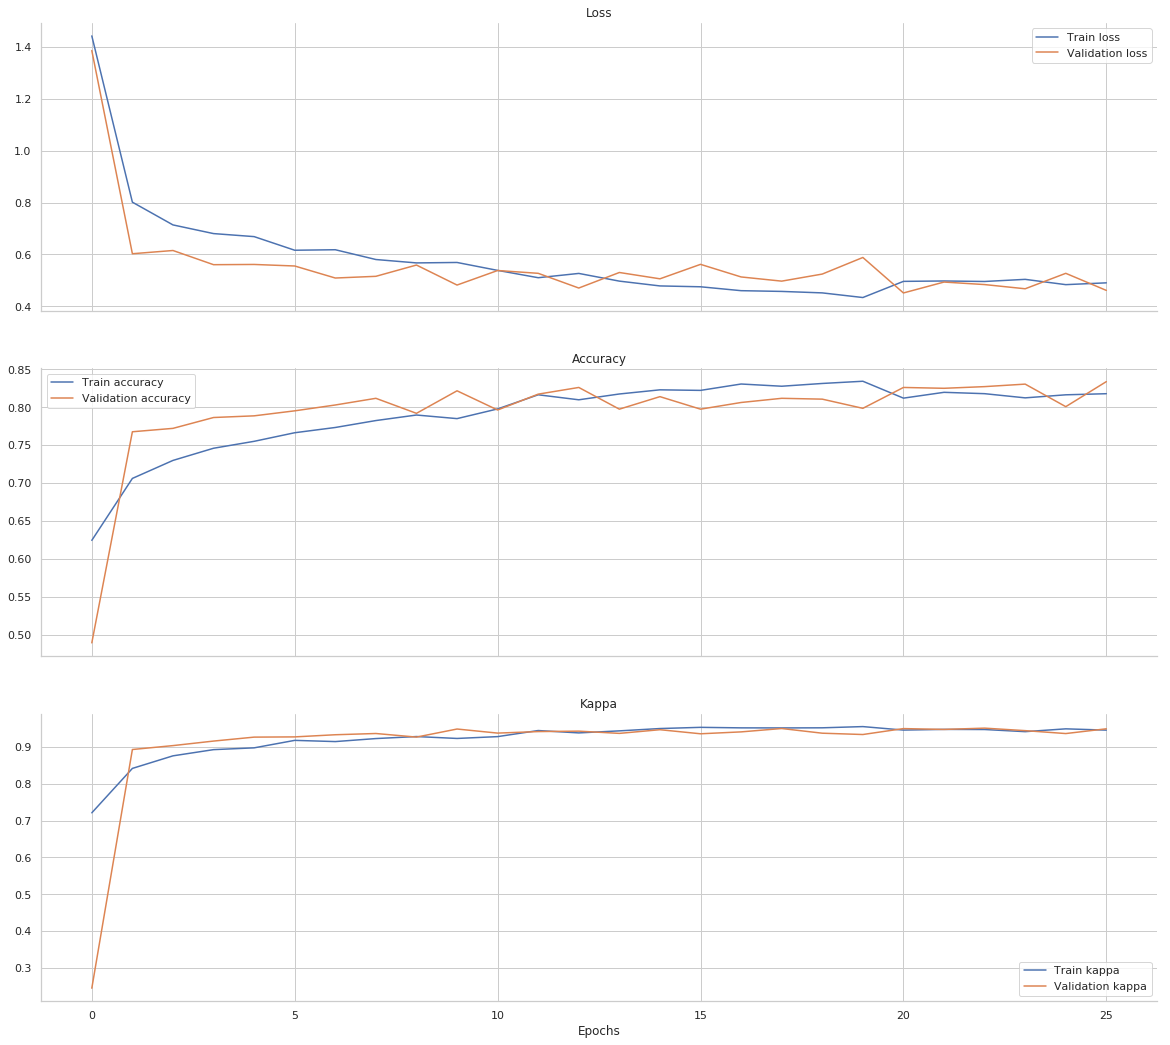

In [14]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'] + history_finetunning_2['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'] + history_finetunning_2['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'] + history_finetunning_2['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc'] + history_finetunning_2['val_acc'], 
           'kappa': history_warmup['kappa'] + history_finetunning['kappa'] + history_finetunning_2['kappa'], 
           'val_kappa': history_warmup['val_kappa'] + history_finetunning['val_kappa'] + history_finetunning_2['val_kappa']}

sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history['kappa'], label='Train kappa')
ax3.plot(history['val_kappa'], label='Validation kappa')
ax3.legend(loc='best')
ax3.set_title('Kappa')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [15]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]
complete_labels = [np.argmax(label) for label in lastFullComLabels]

# Threshold optimization

Label 1: thr=0.460, Kappa=0.738


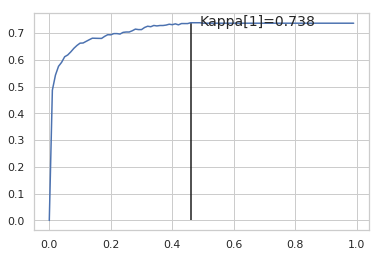

Label 2: thr=0.470, Kappa=0.740


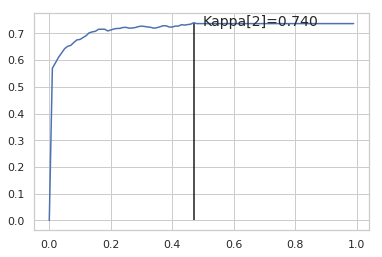

Label 3: thr=0.420, Kappa=0.738


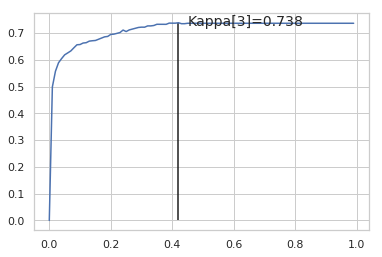

Label 4: thr=0.180, Kappa=0.751


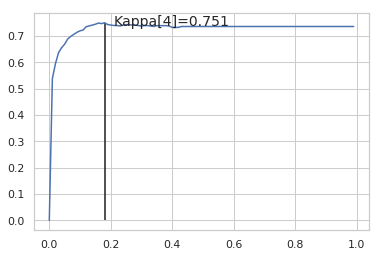

In [16]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    best_thr_list = [0 for i in range(preds.shape[1])]
    for index in range(1, preds.shape[1]):
        score = []
        thrs = np.arange(0, 1, 0.01)
        for thr in thrs:
            preds_thr = [index if x[index] > thr else np.argmax(x) for x in preds]
            score.append(cohen_kappa_score(targs, preds_thr))
        score = np.array(score)
        pm = score.argmax()
        best_thr, best_score = thrs[pm], score[pm].item()
        best_thr_list[index] = best_thr
        print('Label %s: thr=%.3f, Kappa=%.3f' % (index, best_thr, best_score))
        if do_plot:
            plt.plot(thrs, score)
            plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
            plt.text(best_thr+0.03, best_score-0.01, ('Kappa[%s]=%.3f' % (index, best_score)), fontsize=14);
            plt.show()
            
    return best_thr_list

threshold_list = find_best_fixed_threshold(lastFullValPred, validation_labels, do_plot=True)
threshold_list[0] = 0 # In last instance assign label 0

In [17]:
# Apply optimized thresholds to the train predictions
train_preds_opt = [0 for i in range(lastFullTrainPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt[idx2] = idx

# Apply optimized thresholds to the validation predictions
validation_preds_opt = [0 for i in range(lastFullValPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt[idx2] = idx
            
index_order = [0, 2, 1, 4, 3]
# Apply optimized thresholds to the train predictions by class distribution
train_preds_opt2 = [0 for i in range(lastFullTrainPred.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt2[idx2] = idx

# Apply optimized thresholds to the validation predictions by class distribution
validation_preds_opt2 = [0 for i in range(lastFullValPred.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt2[idx2] = idx

# Model Evaluation

## Confusion Matrix

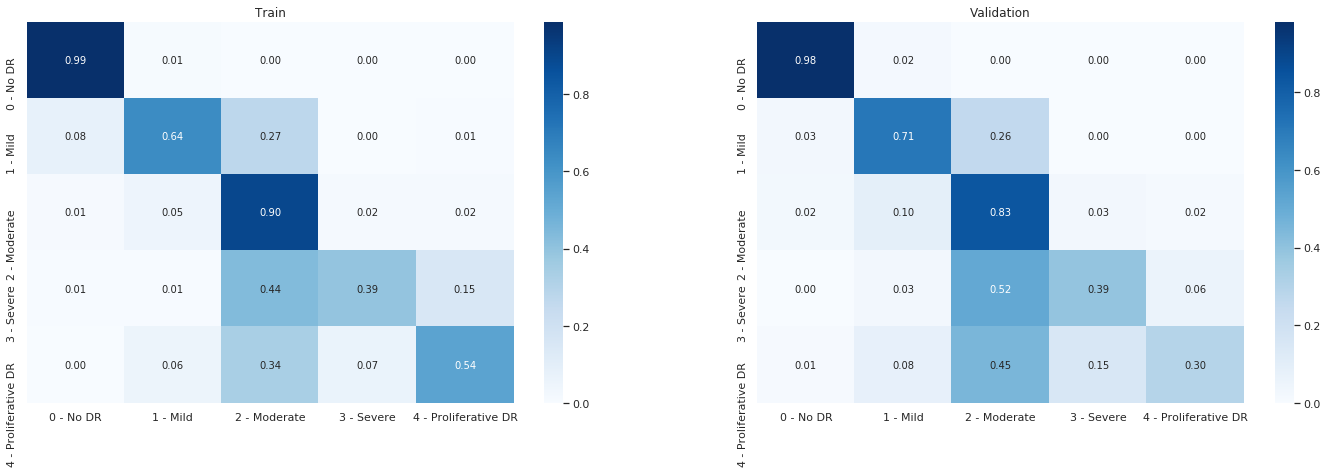

In [18]:
# Original thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation')
plt.show()

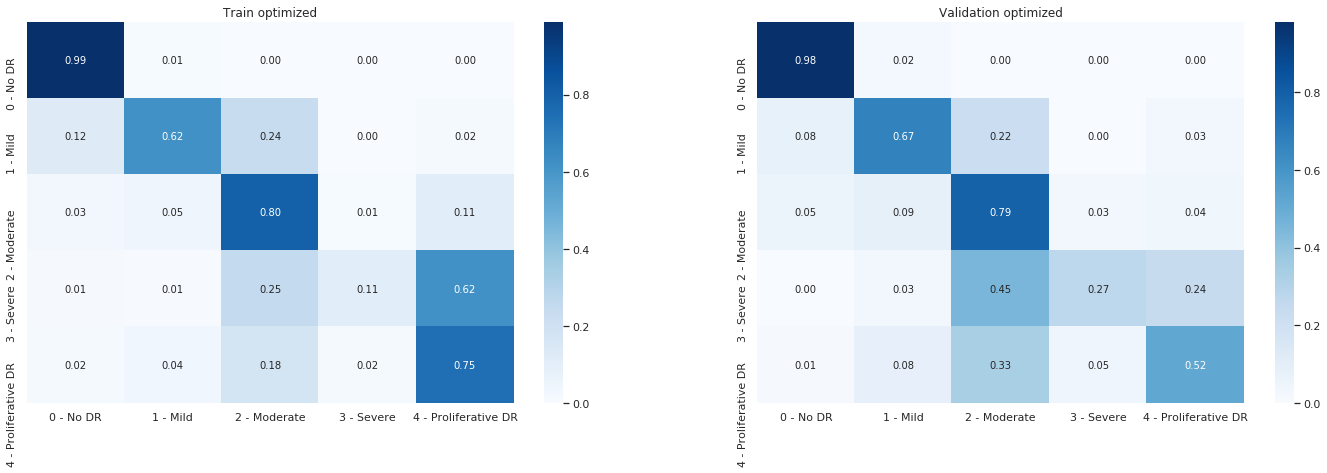

In [19]:
# Optimized thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
train_cnf_matrix = confusion_matrix(train_labels, train_preds_opt)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds_opt)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train optimized')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation optimized')
plt.show()

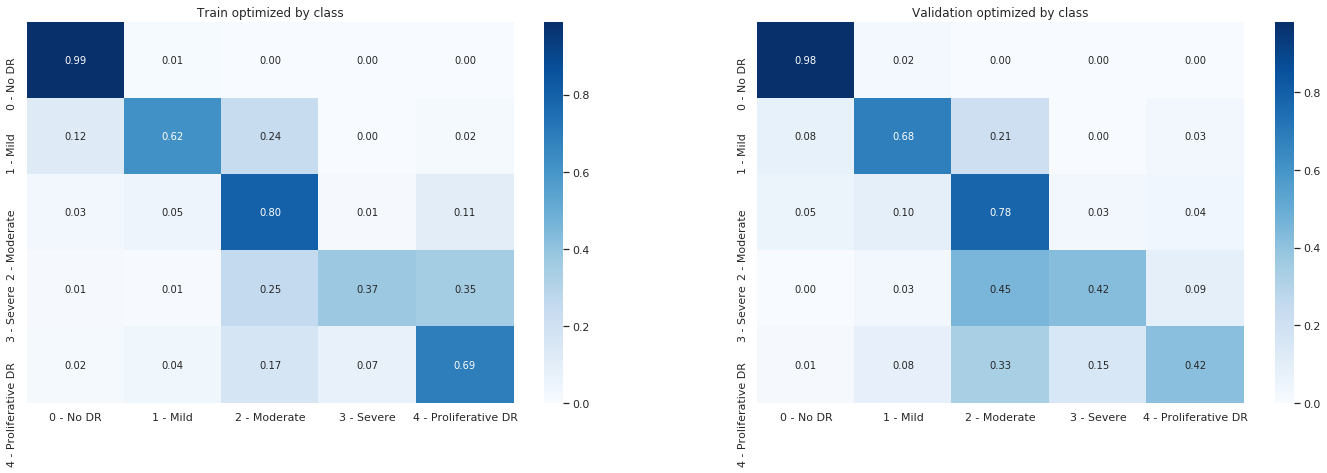

In [20]:
# Optimized thresholds by class
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
train_cnf_matrix = confusion_matrix(train_labels, train_preds_opt2)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds_opt2)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train optimized by class')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation optimized by class')
plt.show()

## Quadratic Weighted Kappa

In [21]:
print(" --- Original thresholds --- ")
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))
print(" --- Optimized thresholds --- ")
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt+validation_preds_opt, train_labels+validation_labels, weights='quadratic'))
print(" --- Optimized thresholds by class distribution --- ")
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt2, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds_opt2, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt2+validation_preds_opt2, train_labels+validation_labels, weights='quadratic'))

 --- Original thresholds --- 
Train Cohen Kappa score: 0.907
Validation Cohen Kappa score: 0.863
Complete set Cohen Kappa score: 0.896
 --- Optimized thresholds --- 
Train Cohen Kappa score: 0.891
Validation Cohen Kappa score: 0.862
Complete set Cohen Kappa score: 0.884
 --- Optimized thresholds by class distribution --- 
Train Cohen Kappa score: 0.891
Validation Cohen Kappa score: 0.858
Complete set Cohen Kappa score: 0.883


## Apply model to test set and output predictions

In [22]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

predictions_opt = [0 for i in range(preds.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt[idx2] = idx

predictions_opt2 = [0 for i in range(preds.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt2[idx2] = idx

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

results_opt2 = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions_opt2})
results_opt2['id_code'] = results_opt2['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

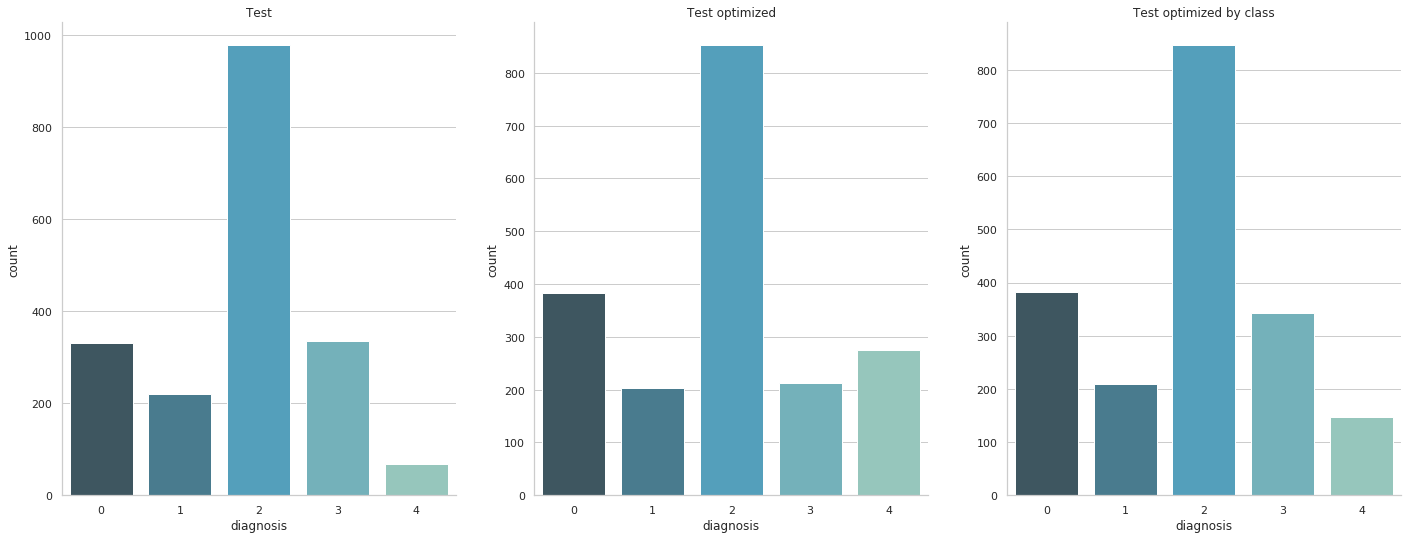

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1).set_title('Test')
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2).set_title('Test optimized')
sns.countplot(x="diagnosis", data=results_opt2, palette="GnBu_d", ax=ax3).set_title('Test optimized by class')
sns.despine()
plt.show()

In [24]:
val_kappa =  cohen_kappa_score(validation_preds, validation_labels, weights='quadratic')
val_opt_kappa = cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic')
val_opt_kappa2 = cohen_kappa_score(validation_preds_opt2, validation_labels, weights='quadratic')

if (val_kappa > val_opt_kappa) and (val_kappa > val_opt_kappa2):
    results_name = 'submission.csv'
    results_opt_name = 'submission_opt.csv'
    results_opt2_name = 'submission_opt2.csv'
elif (val_opt_kappa > val_kappa) and (val_opt_kappa > val_opt_kappa2):
    results_name = 'submission_norm.csv'
    results_opt_name = 'submission.csv'
    results_opt2_name = 'submission_opt2.csv'
else:
    results_name = 'submission_norm.csv'
    results_opt_name = 'submission_opt.csv'
    results_opt2_name = 'submission.csv'

results.to_csv(results_name, index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,1


In [25]:
results_opt.to_csv(results_opt_name, index=False)
results_opt.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4
5,009c019a7309,2
6,010d915e229a,4
7,0111b949947e,1
8,01499815e469,4
9,0167076e7089,1


In [26]:
results_opt2.to_csv(results_opt2_name, index=False)
results_opt2.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,1
